# Deconvolution with PSF estimated from FRC 

In this example I run FRC based blind Richardson Lucy deconvolution on a single 2D confocal microscope image. The image can be downloaded from [here](https://doi.org/10.6084/m9.figshare.8158928.v1). 

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas

import miplib.ui.plots.image as showim
from miplib.psf import psfgen
from miplib.processing.deconvolution import deconvolve
from miplib.data.messages import image_writer_wrappers as imwrap
import miplib.data.io.read as imread
import miplib.processing.image as imops
from miplib.data.containers.image import Image

import miplib.analysis.resolution.fourier_ring_correlation as frc
from miplib.data.containers.fourier_correlation_data import FourierCorrelationDataCollection

import miplib.ui.plots.frc as frcplots

## Setup deconvolution

Setup deconvolution parameters. Most of the times the default values should be fine, but you can of course change anything you like. 

In [2]:
from miplib.ui import deconvolution_options as options
n_iterations = 50
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --resolution-threshold-criterion=fixed "
             " --tv-lambda=0 --bin-delta=1  --frc-curve-fit-type=smooth-spline").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

print (args)

Namespace(block_pad=0, carma_det_idx=0, carma_gate_idx=0, channel=0, convergence_epsilon=0.05, d_angle=20, d_bin=1, d_extract_angle=5.0, debug=False, disable_fft_psf_memmap=False, disable_hamming=False, disable_tau1=False, em_wl=550, estimate_constant=1.0, evaluate_results=False, ex_wl=488, first_estimate='image', frc_curve_fit_degree=8, frc_curve_fit_type='smooth-spline', hanning=False, hollow_iterator=False, image='image', jupyter=False, magnification=1.0, max_nof_iterations=50, memmap_estimates=False, min_filter=False, na=1.4, num_blocks=1, output_cast=False, pinhole_radius=None, psf='psf', psf_shape=(256, 256), psf_size=(4.0, 4.0), psf_type=132, refractive_index=1.414, resol_square=False, resolution_point_sigma=0.01, resolution_snr_value=0.25, resolution_threshold_criterion='fixed', resolution_threshold_curve_fit_degree=3, resolution_threshold_value=0.14285714285714285, rl_background=0.0, save_intermediate_results=False, scale=100, show_image=False, show_plots=False, stop_tau=0.002

## Load an image

The image is from a Nikon A1 confocal system, of a Tubulin stained HeLa cell. There is a zero offset in the image, which I correct here, to make the devonvolution behave nicely. 

In [3]:
# Image
data_dir = os.getcwd()
filename = "Vimentin_029nm.tif"
full_path = os.path.join(data_dir, filename)

image = imread.get_image(full_path, channel=0)

spacing = image.spacing
print ("The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing))

image = Image(image - image.min(), image.spacing)
image_copy = Image(image.copy(), image.spacing)



The image dimensions are (1389, 1389) and spacing [0.028800001013760037, 0.028800001013760037] um.


## Calculate resolution

Here I estimate the resolution of the image with the single-image FRC method. 

Fit starts at 0.414985597134
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 22


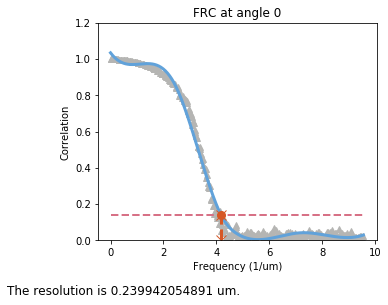

In [4]:
frc_results = FourierCorrelationDataCollection()

frc_results[0] = frc.calculate_single_image_frc(image, args)

plotter = frcplots.FourierDataPlotter(frc_results)
plotter.plot_one(0)

## Generate PSF

Based on the FRC measurement, a PSF is genrated with a simple Gaussian model, using the FRC resolution figure as the FWHM value.  

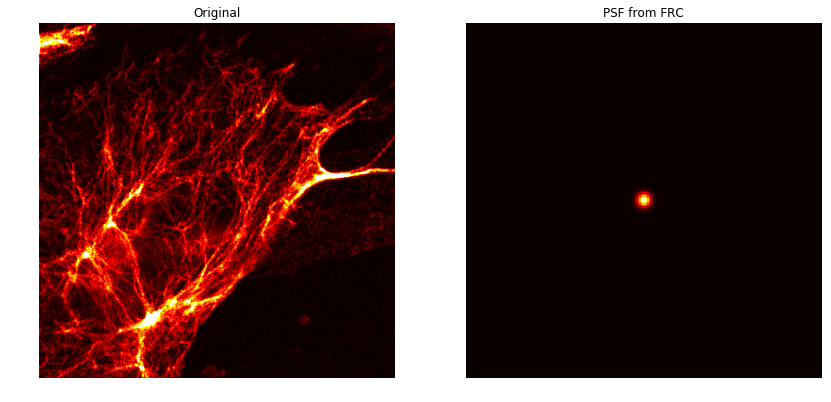

In [5]:

fwhm = [frc_results[0].resolution['resolution'],] * 2

psf_generator = psfgen.PsfFromFwhm(fwhm)

psf = psf_generator.xy()

showim.display_2d_images(imops.enhance_contrast(image_copy, percent_saturated=0.3), 
                         psf,
                         image1_title="Original",
                         image2_title="PSF from FRC"
                         
                    )

## Run deconvolution

Having generated the PSF, deconvolution is now run for 50 iterations. Specifying the TiffImageWriter here is actually not necessary, as the *save-intermediate-images* option is not used (by enabling it you can save each intermediate deconvolution result to the specified directory).

In [6]:

temp_dir = os.path.join(data_dir, "Temp")
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)
    
writer = imwrap.TiffImageWriter(data_dir)

task = deconvolve.DeconvolutionRL(image, psf, writer, args)
task.execute()

/home/parallels/miniconda3/envs/miplib/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


The original image size is [1389 1389]
The deconvolution will be run with 1 blocks
The internal block size is (1389, 1389)
Preparing image fusion.
Beginning the computation of the 0. estimate
[>                 1/50                ] E/S/U/N=0/14541566/11491397/0, LEAK=3.87683218861e-09%, TAU1=0.0553650148213, TIME=0.733s, U/ESU=0.441 
Beginning the computation of the 1. estimate
[=>                2/50                ] ETA:36.5s E/S/U/N=135/20463637/5569191/0, LEAK=8.14684986139e-09%, TAU1=0.033621545881, TIME=0.758s, U/ESU=0.214 
Beginning the computation of the 2. estimate
[=>                3/50                ] ETA:34.0s E/S/U/N=29/23219984/2812950/0, LEAK=-3.44679840225e-09%, TAU1=0.02459942922, TIME=0.680s, U/ESU=0.108 
Beginning the computation of the 3. estimate
[==>               4/50                ] ETA:32.2s E/S/U/N=50/24474138/1558775/0, LEAK=-2.94351210073e-09%, TAU1=0.0195529907942, TIME=0.651s, U/ESU=5.99E-2 
Beginning the computation of the 4. estimate
[===>           

[=================40/50=======>        ] ETA:7.4s E/S/U/N=246/26028090/4627/0, LEAK=4.90899543237e-09%, TAU1=0.0026588672772, TIME=0.781s, U/ESU=1.78E-4 
Beginning the computation of the 40. estimate
[=================41/50========>       ] ETA:6.7s E/S/U/N=589/26028068/4306/0, LEAK=1.2744361122e-09%, TAU1=0.00260343262926, TIME=1.04s, U/ESU=1.65E-4 
Beginning the computation of the 41. estimate
[=================42/50=========>      ] ETA:6.0s E/S/U/N=347/26028586/4029/0, LEAK=-1.31779032131e-09%, TAU1=0.00255057541654, TIME=0.916s, U/ESU=1.55E-4 
Beginning the computation of the 42. estimate
[=================43/50==========>     ] ETA:5.3s E/S/U/N=359/26028848/3755/0, LEAK=-5.98132654517e-09%, TAU1=0.0025001198519, TIME=0.809s, U/ESU=1.44E-4 
Beginning the computation of the 43. estimate
[=================44/50==========>     ] ETA:4.5s E/S/U/N=416/26029043/3503/0, LEAK=-2.31525909555e-09%, TAU1=0.0024519180879, TIME=0.800s, U/ESU=1.35E-4 
Beginning the computation of the 44. estima

## Results

Get and show result

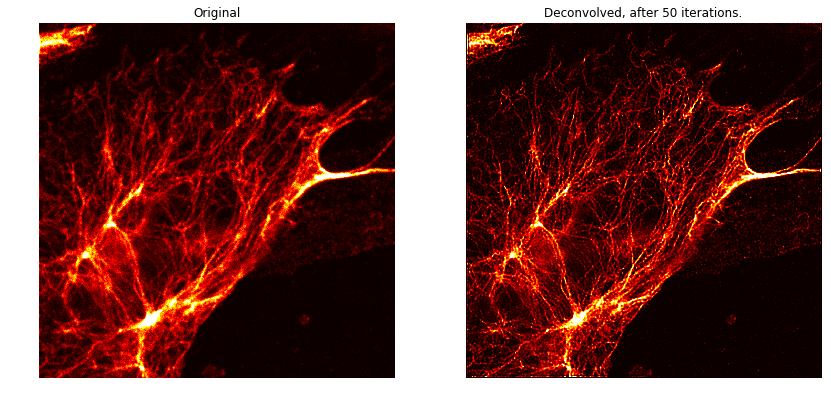

In [7]:
rl_result = task.get_result()

showim.display_2d_images(imops.enhance_contrast(image, percent_saturated=0.3), 
                         imops.enhance_contrast(rl_result, percent_saturated=0.3),
                         image1_title="Original",
                         image2_title="Deconvolved, after {} iterations.".format(n_iterations))




## Evaluate the deconvolution quality

Here for the sake of simplicity I only analyze the last deconvolution result with FRC. It is of coruse possible to do that for each intermediate estimate, to get the progress curves that were shown in the (Koho S. et al. Nat. Communications 2019) paper

Fit starts at 0.677233457565
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 10
         Function evaluations: 20


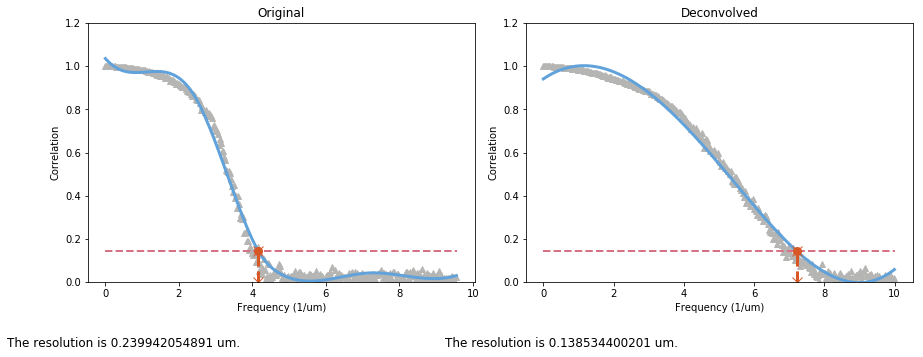

In [8]:
frc_results[1] = frc.calculate_single_image_frc(rl_result, args)

plotter = frcplots.FourierDataPlotter(frc_results)
plotter.plot_all(custom_titles=("Original", "Deconvolved"))